## Context

Avui dia, es construeixen sistemes sofisticats per detectar atacs a servidors i contingut sospitós.

El contingut és més que simples files i columnes. Faciliteu l'inici d'altres descrivint com va adquirir les dades i el període de temps que representen.

## Contingut

CIDDS (Conjunts de Dades de Detecció d'Intrusions de Coburg) és un concepte per crear conjunts de dades d'avaluació per a sistemes de detecció d'intrusions a la xarxa basats en anomalies.

[Més informació](https://www.kaggle.com/datasets/kartikjaspal/server-logs-suspicious/dat)

In [1]:
# Importació de les biblioteques
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay

In [2]:
# Importar dades des del Drive
from google.colab import drive

drive.mount('/content/drive',force_remount=True)
ruta = '/content/drive/MyDrive/'
!mkdir = {ruta + 'CEFP/'} 2> /dev/null
!mkdir = {ruta + 'CEFP/M06/'} 2> /dev/null
!mkdir = {ruta + "CEFP/M06/'Prova logs server'/"} 2> /dev/null

ruta = "/content/drive/MyDrive/CEFP/M06/Prova logs server"

try:
  drive.mount('/content/drive', force_remount=True)
  os.chdir(ruta + "/")
except:
  pass

Mounted at /content/drive
Mounted at /content/drive


In [3]:
logs_df = pd.read_csv('CIDDS_001_external_week1.csv', delimiter=",")

In [4]:
logs_df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,.AP...,0,normal,---,---,---
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,.AP...,0,normal,---,---,---
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,.AP...,0,normal,---,---,---
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,1,.AP...,0,normal,---,---,---
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,1,.AP.S.,0,normal,---,---,---


In [5]:
# Tractament de valors duplicats.
duplicats = logs_df[logs_df.duplicated()]

duplicats

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription


In [6]:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172838 entries, 0 to 172837
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date first seen    172838 non-null  object 
 1   Duration           172838 non-null  float64
 2   Proto              172838 non-null  object 
 3   Src IP Addr        172838 non-null  object 
 4   Src Pt             172838 non-null  int64  
 5   Dst IP Addr        172838 non-null  object 
 6   Dst Pt             172838 non-null  float64
 7   Packets            172838 non-null  int64  
 8   Bytes              172838 non-null  object 
 9   Flows              172838 non-null  int64  
 10  Flags              172838 non-null  object 
 11  Tos                172838 non-null  int64  
 12  class              172838 non-null  object 
 13  attackType         172838 non-null  object 
 14  attackID           172838 non-null  object 
 15  attackDescription  172838 non-null  object 
dtypes:

In [7]:
logs_df.isnull().sum()

,0
Date first seen,0
Duration,0
Proto,0
Src IP Addr,0
Src Pt,0
Dst IP Addr,0
Dst Pt,0
Packets,0
Bytes,0
Flows,0


In [8]:
attack_type = logs_df['attackType'].unique()
attack_id = logs_df['attackID'].unique()
attack_description = logs_df['attackDescription'].unique()

print(attack_type)
print(attack_id)
print(attack_description)

['---']
['---']
['---']


In [9]:
logs_df.groupby(['class']).count()['Duration']

,Duration
class,
normal,49606
suspicious,107344
unknown,15888


Text(0, 0.5, 'tipus de detecció logs')

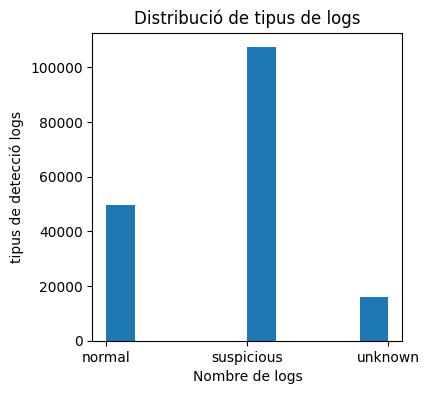

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(logs_df['class'])
ax.set_title('Distribució de tipus de logs')
ax.set_xlabel('Nombre de logs')
ax.set_ylabel('tipus de detecció logs')

El camp de "Flags" és una cadena de diverses variables de "Flags" que són necessàries en el camp de les xarxes. Allà on no estigui establerta una certa "Flag", s'utilitza un ".". Necessitem dividir aquesta columna en variables individuals per a les "Flags", ja que ajudarà el model a aprendre més ràpidament i establir millors relacions.

- "A" significa "Actiu" o "Acceptat".

- "P" significa "Processat" o "Pendent".

- "S" significa "Segur" o "Satisfactori".

- "R" significa "Rebutjat" o "Rebut".

- "F" significa "Falut" o "Finalitzat".

- "0x" són valors en format hexadecimal. Això pot ser una representació d'un codi o identificador específic als logs

In [11]:
logs_df["Flags"].unique()

array(['.AP...', '.AP.S.', '....S.', '.A.R..', '.APRS.', '.APRSF',
       '.AP.SF', '......', '  0xdb', '...RS.', '.A..S.', '.A..SF',
       '.A.RS.', '.A.RSF', '...R..', '.A....', '  0xd2', '.A.R.F',
       '  0xc2', '  0xda', '  0xd7', '  0x53', '  0xdf', '  0xd6',
       '  0xd3'], dtype=object)

In [12]:
logs_df["A"]=0
logs_df["P"]=0
logs_df["S"]=0
logs_df["R"]=0
logs_df["F"]=0
logs_df["x"]=0

def set_flag(data,check):
  val=0;
  if(check in list(data["Flags"])):
    val = 1 ;
  return val;

In [13]:
logs_df["A"] = logs_df.apply(set_flag,check ="A", axis = 1)
logs_df["P"] = logs_df.apply(set_flag,check = "P" ,axis = 1)
logs_df["S"] = logs_df.apply(set_flag,check ="S",axis = 1)
logs_df["R"] = logs_df.apply(set_flag,check="R" ,axis = 1)
logs_df["F"] = logs_df.apply(set_flag,check ="F" ,axis = 1)
logs_df["x"] = logs_df.apply(set_flag,check ="x" ,axis = 1)

In [14]:
logs_flags_df = (logs_df[['A', 'P', 'S', 'R', 'F', 'x']] == 1).sum()

In [15]:
logs_df.head()

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,...,class,attackType,attackID,attackDescription,A,P,S,R,F,x
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,...,normal,---,---,---,1,1,0,0,0,0
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,...,normal,---,---,---,1,1,0,0,0,0
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,...,normal,---,---,---,1,1,0,0,0,0
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,1,...,normal,---,---,---,1,1,0,0,0,0
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,1,...,normal,---,---,---,1,1,1,0,0,0


Text(0, 0.5, 'Tipus de protocols')

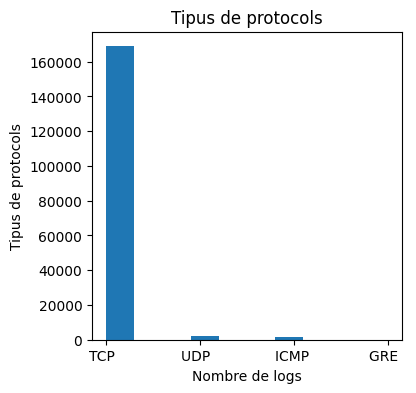

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(logs_df['Proto'])
ax.set_title('Tipus de protocols')
ax.set_xlabel('Nombre de logs')
ax.set_ylabel('Tipus de protocols')

In [17]:
logs_df = logs_df.drop(["Date first seen", "attackType", "attackID", "attackDescription", "Flows", "Tos", "Flags", "Proto", "Bytes", "A", "S", "R", "x"], axis=1)

In [18]:
logs_df = logs_df[logs_df['class'] != 'unknown']

In [19]:
logs_df.groupby(['class']).count()['Duration']

,Duration
class,
normal,49606
suspicious,107344


In [20]:
logs_df.head()

,Duration,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,class,P,F
0,81412.697,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,normal,1,0
1,81412.697,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,normal,1,0
2,81504.787,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,normal,1,0
3,81504.787,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,normal,1,0
4,82100.692,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,normal,1,0


In [21]:
logs_df[logs_df['class'] == 'suspicious']

,Duration,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,class,P,F
16,0.000,10000_214,8830,EXT_SERVER,23.0,1,suspicious,0,0
17,0.000,EXT_SERVER,23,10000_214,8830.0,1,suspicious,0,0
18,15.420,EXT_SERVER,22,10001_123,4589.0,19,suspicious,1,0
19,15.420,10001_123,4589,EXT_SERVER,22.0,13,suspicious,1,0
20,0.000,10002_148,18816,EXT_SERVER,23.0,1,suspicious,0,0
...,...,...,...,...,...,...,...,...,...
172817,12.660,EXT_SERVER,22,18851_139,14878.0,24,suspicious,1,1
172818,30.999,19393_59,47427,EXT_SERVER,22.0,1,suspicious,0,0
172819,30.999,EXT_SERVER,22,19393_59,47427.0,6,suspicious,0,0
172820,31.004,18851_139,19843,EXT_SERVER,22.0,2,suspicious,0,0


In [22]:
logs_df.groupby(['Src IP Addr']).count()['Duration']

,Duration
Src IP Addr,
10000_214,1
10001_101,6
10001_123,164
10001_15,341
10001_5,4
...,...
19391_14,1
19392_172,1
19393_59,1


In [23]:
logs_df.groupby(['Dst IP Addr']).count()['Duration']

,Duration
Dst IP Addr,
10000_214,1
10001_101,6
10001_123,164
10001_15,341
10001_5,4
...,...
19391_14,1
19392_172,1
19393_59,1


In [24]:
# Categoritzar les dades.
cat_cols = ["Src IP Addr", "Dst IP Addr", "class"]

encoder = LabelEncoder()

for column in cat_cols:
  # Label encoder
  logs_df[column] = encoder.fit_transform(logs_df[column])

In [25]:
logs_df.head()

,Duration,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,class,P,F
0,81412.697,10079,8082,10019,56978.0,3057,0,1,0
1,81412.697,10080,56978,10018,8082.0,4748,0,1,0
2,81504.787,10079,8082,10019,56979.0,8639,0,1,0
3,81504.787,10080,56979,10018,8082.0,12024,0,1,0
4,82100.692,10079,8082,10019,51649.0,11012,0,1,0


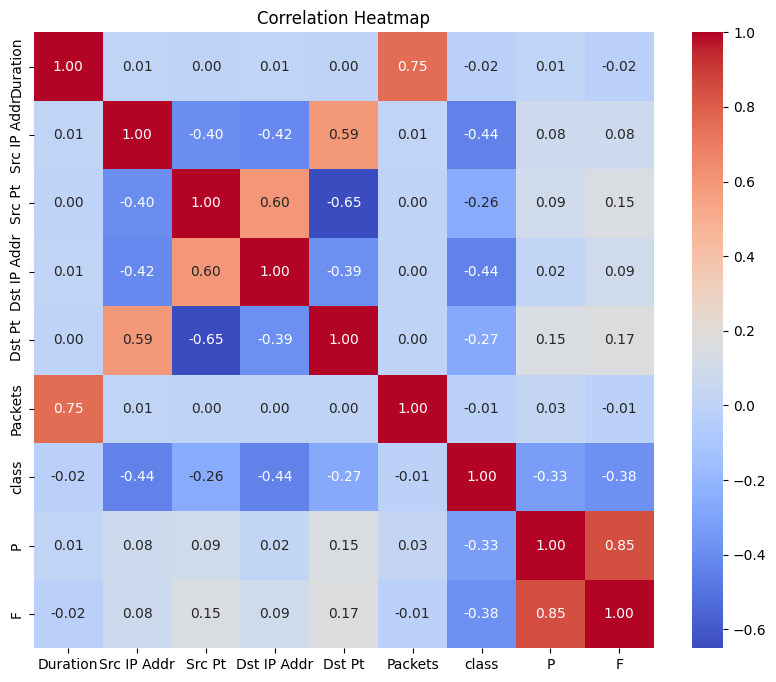

In [26]:
# Calcular matriu de correlació

correlation_matrix = logs_df.corr()

# Mostrar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [27]:
# Divisió prèvia de les dades del dataframe. "x" seran les característiques i "y" serà la columna objectiu
x = logs_df.drop(['class'], axis=1)
y = logs_df['class']

In [28]:
# Divisió de les dades per a entrenament (70%) i per a test (30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [29]:
# Inicialització del classificador
decision_tree = DecisionTreeClassifier(random_state=42)

# Entrenament del classificador
decision_tree.fit(x_train, y_train)

# Realització de les prediccions
decision_tree_prediccions = decision_tree.predict(x_test)

Exactitud: 1.0000
Precisió: 1.0000


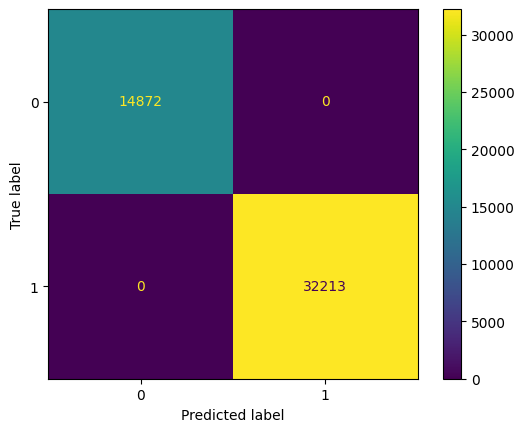

In [30]:
# Creació de la matriu de confusió
ConfusionMatrixDisplay.from_predictions(y_test, decision_tree_prediccions);

decision_tree_accuracy = accuracy_score(y_test, decision_tree_prediccions)
decision_tree_precision = precision_score(y_test, decision_tree_prediccions, average='weighted')

# Mostra de les mètriques amb 4 decimals
print(f"Exactitud: {decision_tree_accuracy:.4f}")
print(f"Precisió: {decision_tree_precision:.4f}")

In [31]:
logs_df.to_csv('logs_v1.csv', sep=';', encoding='utf-8', index=False)

In [32]:
# Barrejar el DataFrame de manera aleatòria
df_shuffled = logs_df.sample(frac=1).reset_index(drop=True)

# Dividir el DataFrame en 3 parts
df1 = df_shuffled[:len(df_shuffled)//3]
df1.to_csv('logs_client_id_1.csv', sep=';', encoding='utf-8', index=False)

df2 = df_shuffled[len(df_shuffled)//3:2*(len(df_shuffled)//3)]
df2.to_csv('logs_client_id_2.csv', sep=';', encoding='utf-8', index=False)

df3 = df_shuffled[2*(len(df_shuffled)//3):]
df3.to_csv('logs_client_id_3.csv', sep=';', encoding='utf-8', index=False)
